In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

## Question 1
* The data was downloaded from yahoo as csv files.
* Closing daily prices are used for further analysis

In [3]:
appleData=pd.read_csv('stockdata/AAPL.csv')
googleData=pd.read_csv('stockdata/GOOGL.csv')
fbData=pd.read_csv('stockdata/FB.csv')

In [4]:
#set date as index and take only closing price of the stock
fbClose=(fbData.set_index('Date'))[['Close']]
appleClose=(appleData.set_index('Date'))[['Close']]
googleClose=(googleData.set_index('Date'))[['Close']]
# rename column for following merging with other stock data
fbClose.columns = ['FB']
appleClose.columns = ['AAPL']
googleClose.columns = ['GOOGL']

In [5]:
allData=pd.concat((fbClose, appleClose, googleClose), axis = 1)

In [6]:
returnsData=pd.DataFrame()
returnsData['FB'] = (allData['FB'].shift(-1) - allData['FB'])/allData['FB']
returnsData['AAPL'] = (allData['AAPL'].shift(-1) - allData['AAPL'])/allData['AAPL']
returnsData['GOOGL'] = (allData['GOOGL'].shift(-1) - allData['GOOGL'])/allData['GOOGL']

In [7]:
normalizedReturns=(returnsData-returnsData.mean())/returnsData.std()

## Question 2
### Calculation of some basic statistics of stocks returns

In [8]:
returnsData.describe()

,FB,AAPL,GOOGL
count,1590.000000,2517.000000,2517.000000
mean,0.001176,0.001138,0.000822
std,0.023416,0.018659,0.017312
min,-0.189609,-0.179195,-0.116091
25%,-0.009002,-0.007270,-0.006627
50%,0.000937,0.000905,0.000647
75%,0.011812,0.010274,0.008858
max,0.296115,0.139050,0.162584


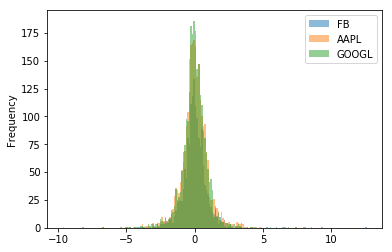

In [11]:
#lets have a look at returns distributions
plt.figure();
normalizedReturns.plot.hist(bins=200, alpha=0.5)
plt.show()

### Defining the  distribution of stocks returns

In [204]:
def findDistribution(sample):
    
    """
    Takes numpy array as input
    fits input against probability distributions from "cdfs" list
    and applies kolmagorof-smirnov test.
    Output is probability of each distribution to describe our data and corresponding p-value
    """
    
    cdfs = [
        "norm",            #Normal (Gaussian)
        "t",               #Student's T
        "lognorm",         #Log-Normal
        "gamma"            #Gamma continuous random variable.
    ]
    for cdf in cdfs:
        #fit data  against few probability distributions
        parameters = eval("stats."+cdf+".fit(sample)")
        #Applying the Kolmogorov-Smirnof one sided test
        D, p = stats.kstest(sample, cdf, args=parameters)
        print(cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"p-value: "+str(D))

In [205]:
findDistribution(normalizedReturns['AAPL'].dropna().as_matrix())

norm            p: 4.30766533555e-14     p-value: 0.0789490202752
t               p: 0.662372404016        p-value: 0.0145330469309
lognorm         p: 4.61852778244e-14     p-value: 0.0788624500189
gamma           p: 0.0                   p-value: 0.0865240019566


In [206]:
findDistribution(normalizedReturns['FB'].dropna().as_matrix())

norm            p: 6.57252030578e-14     p-value: 0.098603673796
t               p: 0.607294017841        p-value: 0.0191055166867
lognorm         p: 1.27675647832e-13     p-value: 0.0975444112915
gamma           p: 8.881784197e-16       p-value: 0.105261534996


In [207]:
findDistribution(normalizedReturns['GOOGL'].dropna().as_matrix())

norm            p: 2.22044604925e-16     p-value: 0.085983383324
t               p: 0.657649585589        p-value: 0.0145888674173
lognorm         p: 0.0                   p-value: 0.0887365162061
gamma           p: 0.0                   p-value: 0.0925942930021


Lets apply Augmented Dickey-Fuller test as a unit root test to check wether our returns are stationary over time. The test results is less than critical value for each stock for all p-value thresholds, meaning that our stock returns data is stationary

In [29]:
def DickeyFuller(X):
    
    """Apply Augmented Dickey-Fuller test
    to array X (representing time series)
    The function returns statistics value
    and 3 critical levels for different p-values
    """
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [30]:
DickeyFuller(normalizedReturns['GOOGL'].dropna().as_matrix())

ADF Statistic: -50.575507
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [31]:
DickeyFuller(normalizedReturns['FB'].dropna().as_matrix())

ADF Statistic: -39.672083
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [32]:
DickeyFuller(normalizedReturns['AAPL'].dropna().as_matrix())

ADF Statistic: -15.228896
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Checking for autocorrelation 

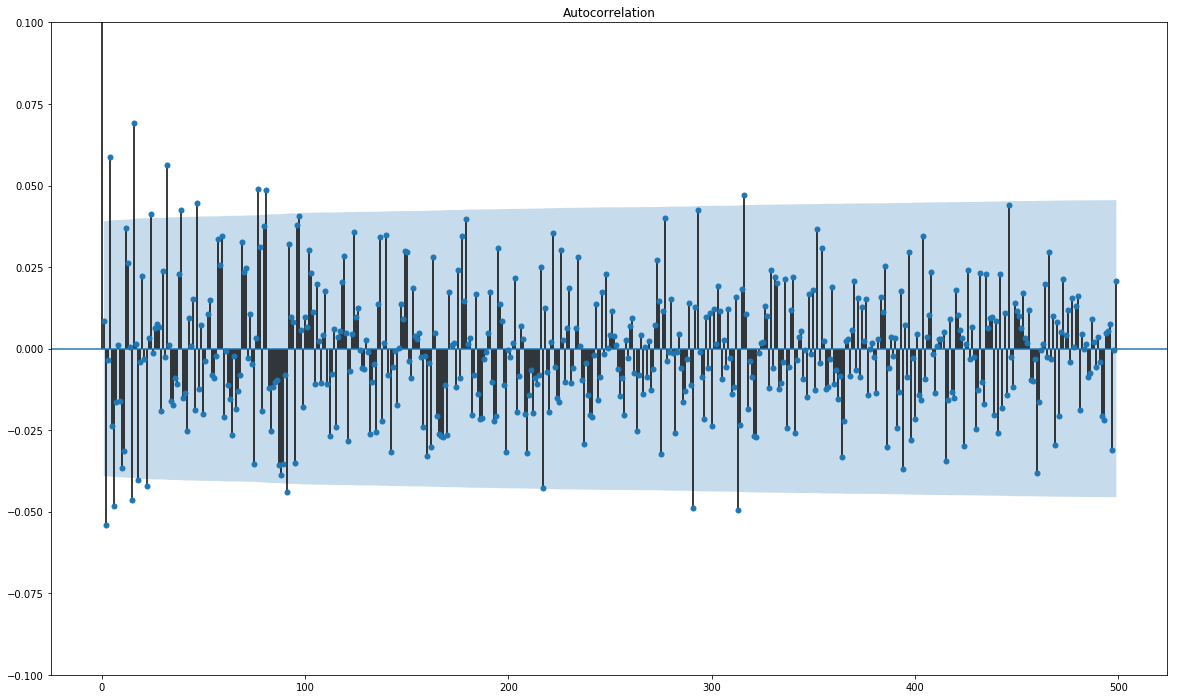

In [32]:
series=normalizedReturns['AAPL'].dropna()
plot_acf(series, lags=np.arange(500))
plt.rcParams['figure.figsize']=(20,12)
axes = plt.gca()
axes.set_ylim([-0.1,0.1])
plt.show()

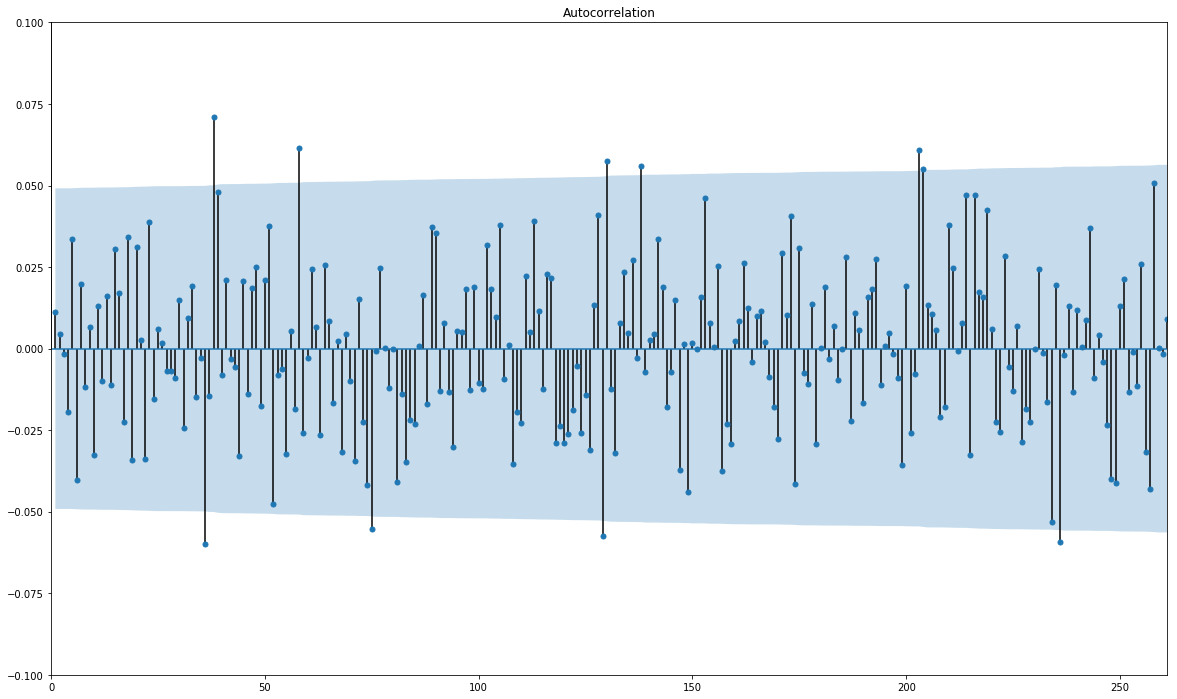

In [18]:
series=normalizedReturns['FB'].dropna()
plot_acf(series)
plt.rcParams['figure.figsize']=(20,12)
axes = plt.gca()
axes.set_ylim([-0.1,0.1])
axes.set_xlim([0,261])
plt.show()

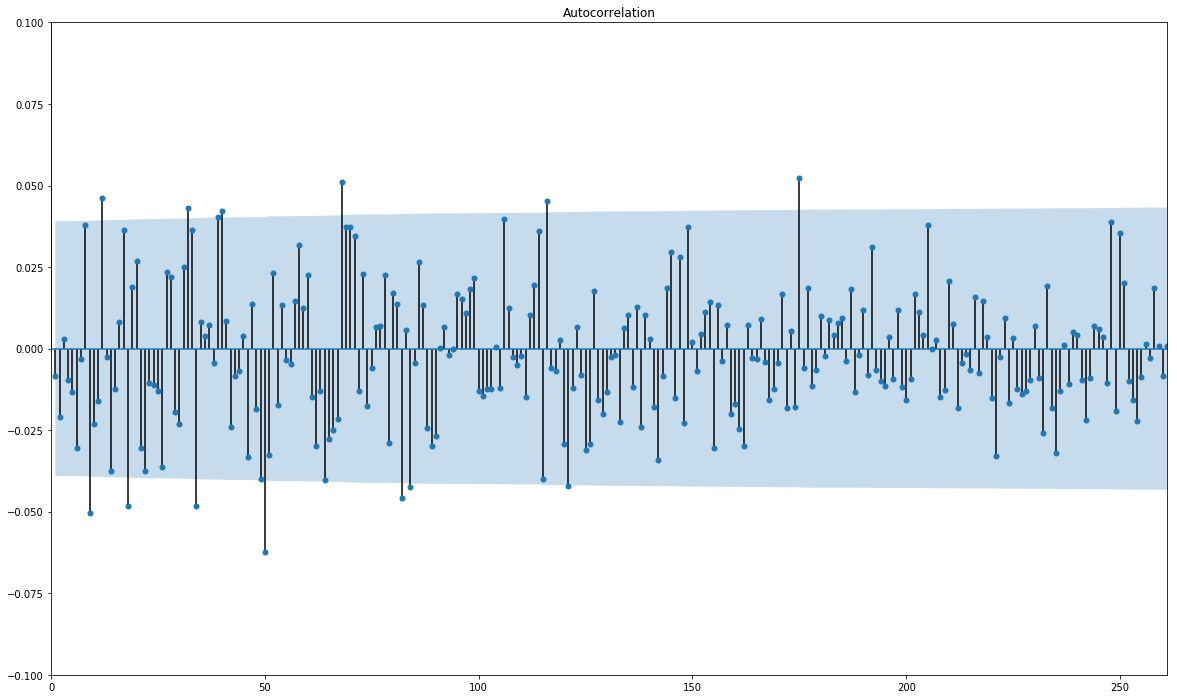

In [20]:
series=normalizedReturns['GOOGL'].dropna().as_matrix()
plot_acf(series)
plt.rcParams['figure.figsize']=(20,12)
axes = plt.gca()
axes.set_ylim([-0.1,0.1])
axes.set_xlim([0,261])

plt.show()

## Relationships between stocks

In [12]:
#calculate correlation matrix
corrTable=normalizedReturns.corr(method='pearson', min_periods=1)
corrTable

,FB,AAPL,GOOGL
FB,1.000000,0.237798,0.374746
AAPL,0.237798,1.000000,0.528093
GOOGL,0.374746,0.528093,1.000000


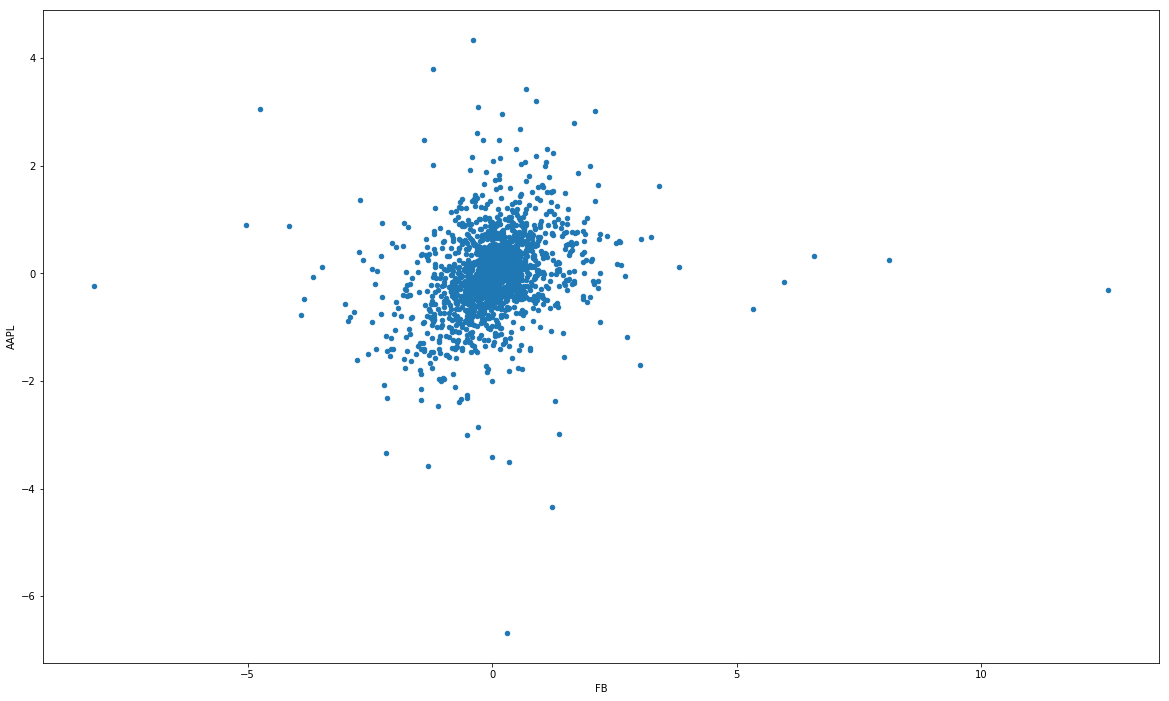

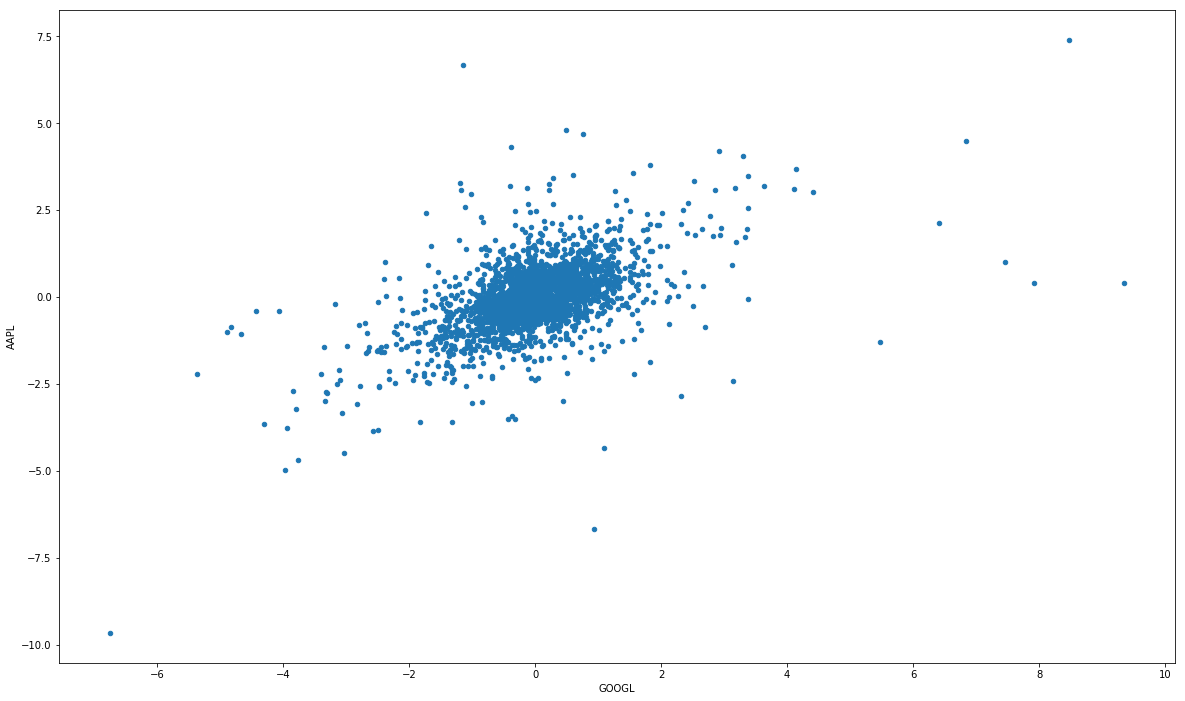

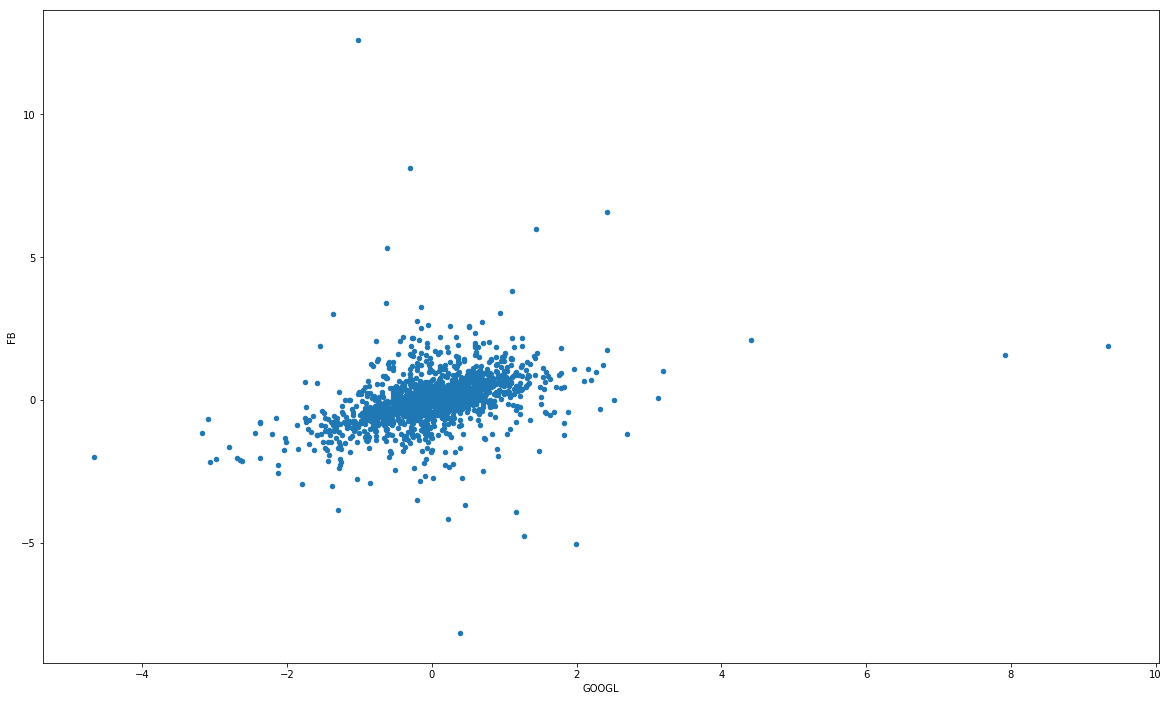

In [72]:
normalizedReturns.plot.scatter('FB', 'AAPL')
normalizedReturns.plot.scatter('GOOGL', 'AAPL')
normalizedReturns.plot.scatter('GOOGL', 'FB')
plt.show()

In [26]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(normalizedReturns.dropna())
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2', 'PCA3'])

In [27]:
print(pca.explained_variance_ratio_)

[ 0.56241586  0.2631698   0.17441435]


The first principle component can explain 56% of variability 

All time series are stationary. Thus, we can use granger causality test 

In [71]:
grangercausalitytests(returnsData[['AAPL','GOOGL']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9446  , p=0.1633  , df_denom=2513, df_num=1
ssr based chi2 test:   chi2=1.9470  , p=0.1629  , df=1
likelihood ratio test: chi2=1.9462  , p=0.1630  , df=1
parameter F test:         F=1.9446  , p=0.1633  , df_denom=2513, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8950  , p=0.1505  , df_denom=2510, df_num=2
ssr based chi2 test:   chi2=3.7975  , p=0.1498  , df=2
likelihood ratio test: chi2=3.7946  , p=0.1500  , df=2
parameter F test:         F=1.8950  , p=0.1505  , df_denom=2510, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2783  , p=0.2801  , df_denom=2507, df_num=3
ssr based chi2 test:   chi2=3.8456  , p=0.2786  , df=3
likelihood ratio test: chi2=3.8427  , p=0.2790  , df=3
parameter F test:         F=1.2783  , p=0.2801  , df_denom=2507, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9692  , p=0.

{1: ({'lrtest': (1.94620496994321, 0.16299638899446345, 1),
   'params_ftest': (1.944636397463273, 0.16328926491701912, 2513.0, 1),
   'ssr_chi2test': (1.9469578893822683, 0.16291504462288831, 1),
   'ssr_ftest': (1.944636397463291, 0.16328926491701912, 2513.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (3.7946066753538616, 0.14997249960255696, 2),
   'params_ftest': (1.8949605520699897, 0.15053926032726214, 2510.0, 2),
   'ssr_chi2test': (3.797470747773843, 0.14975788725562514, 2),
   'ssr_ftest': (1.8949605520700488, 0.15053926032726214, 2510.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (3.8426607043948025, 0.27896281832248349, 3),
   'params_ftest': (1.2782970832470271, 0.28010251912559553, 2507.0, 3),
   'ssr_chi2test': (3.8455989636413892, 0.27862657239745514, 3),
   'ssr_ftest': (1.2782970832470117, 0.28010251912567924, 2507.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1., 

In [72]:
grangercausalitytests(returnsData[['GOOGL', 'AAPL']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2491  , p=0.0716  , df_denom=2513, df_num=1
ssr based chi2 test:   chi2=3.2530  , p=0.0713  , df=1
likelihood ratio test: chi2=3.2509  , p=0.0714  , df=1
parameter F test:         F=3.2491  , p=0.0716  , df_denom=2513, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8093  , p=0.1640  , df_denom=2510, df_num=2
ssr based chi2 test:   chi2=3.6259  , p=0.1632  , df=2
likelihood ratio test: chi2=3.6232  , p=0.1634  , df=2
parameter F test:         F=1.8093  , p=0.1640  , df_denom=2510, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4516  , p=0.0617  , df_denom=2507, df_num=3
ssr based chi2 test:   chi2=7.3753  , p=0.0609  , df=3
likelihood ratio test: chi2=7.3645  , p=0.0611  , df=3
parameter F test:         F=2.4516  , p=0.0617  , df_denom=2507, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1029  , p=0.

{1: ({'lrtest': (3.2508902544577722, 0.0713846759605158, 1),
   'params_ftest': (3.2491126098562848, 0.071581907413187554, 2513.0, 1),
   'ssr_chi2test': (3.252991375406578, 0.071293235192633073, 1),
   'ssr_ftest': (3.2491126098556165, 0.07158190741321574, 2513.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (3.6232450619500014, 0.163388818198588, 2),
   'params_ftest': (1.8093238877283917, 0.16397834612079795, 2510.0, 2),
   'ssr_chi2test': (3.625856237160539, 0.16317563897506582, 2),
   'ssr_ftest': (1.8093238877282214, 0.16397834612081313, 2510.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (7.3644769536658714, 0.061144797938983787, 3),
   'params_ftest': (2.4515794751302908, 0.061665748530806259, 2507.0, 3),
   'ssr_chi2test': (7.3752741928330696, 0.060851299975065005, 3),
   'ssr_ftest': (2.4515794751302713, 0.061665748530806259, 2507.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,

In [73]:
grangercausalitytests(returnsData[['GOOGL', 'FB']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5573  , p=0.2122  , df_denom=1586, df_num=1
ssr based chi2 test:   chi2=1.5603  , p=0.2116  , df=1
likelihood ratio test: chi2=1.5595  , p=0.2117  , df=1
parameter F test:         F=1.5573  , p=0.2122  , df_denom=1586, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5129  , p=0.5989  , df_denom=1583, df_num=2
ssr based chi2 test:   chi2=1.0290  , p=0.5978  , df=2
likelihood ratio test: chi2=1.0287  , p=0.5979  , df=2
parameter F test:         F=0.5129  , p=0.5989  , df_denom=1583, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4570  , p=0.7124  , df_denom=1580, df_num=3
ssr based chi2 test:   chi2=1.3772  , p=0.7109  , df=3
likelihood ratio test: chi2=1.3766  , p=0.7110  , df=3
parameter F test:         F=0.4570  , p=0.7124  , df_denom=1580, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6519  , p=0.

{1: ({'lrtest': (1.5595095022981695, 0.21173705301163076, 1),
   'params_ftest': (1.5573292680371025, 0.21224090454596695, 1586.0, 1),
   'ssr_chi2test': (1.56027503588353, 0.21162495427485387, 1),
   'ssr_ftest': (1.5573292680373059, 0.21224090454588357, 1586.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (1.0286719829255162, 0.59789747186442876, 2),
   'params_ftest': (0.51288264484342072, 0.59886651887120412, 1583.0, 2),
   'ssr_chi2test': (1.0290052305894315, 0.59779785619595172, 2),
   'ssr_ftest': (0.51288264484353596, 0.5988665188711515, 1583.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (1.3765993826491467, 0.71102901603386148, 3),
   'params_ftest': (0.45704067023921269, 0.71235552806430658, 1580.0, 3),
   'ssr_chi2test': (1.3771966019045849, 0.71088857140033435, 3),
   'ssr_ftest': (0.45704067023928674, 0.7123555280642655, 1580.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., 

In [74]:
grangercausalitytests(returnsData[['FB', 'GOOGL']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9746  , df_denom=1586, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9746  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9746  , df=1
parameter F test:         F=0.0010  , p=0.9746  , df_denom=1586, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5137  , p=0.5984  , df_denom=1583, df_num=2
ssr based chi2 test:   chi2=1.0307  , p=0.5973  , df=2
likelihood ratio test: chi2=1.0304  , p=0.5974  , df=2
parameter F test:         F=0.5137  , p=0.5984  , df_denom=1583, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9714  , p=0.4053  , df_denom=1580, df_num=3
ssr based chi2 test:   chi2=2.9272  , p=0.4030  , df=3
likelihood ratio test: chi2=2.9245  , p=0.4034  , df=3
parameter F test:         F=0.9714  , p=0.4053  , df_denom=1580, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8821  , p=0.

{1: ({'lrtest': (0.001014879500871757, 0.97458595191740383, 1),
   'params_ftest': (0.0010129637497767231, 0.97461394632829268, 1586.0, 1),
   'ssr_chi2test': (0.0010148798224209139, 0.97458594789273834, 1),
   'ssr_ftest': (0.0010129637497542916, 0.97461394633270404, 1586.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (1.0303985298996849, 0.59738154555376699, 2),
   'params_ftest': (0.51374375831120689, 0.5983513827558895, 1583.0, 2),
   'ssr_chi2test': (1.0307328972812249, 0.59728168145024074, 2),
   'ssr_ftest': (0.5137437583111395, 0.5983513827558895, 1583.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (2.9245245041747694, 0.40340899766847571, 3),
   'params_ftest': (0.97143644029938547, 0.40530634318572856, 1580.0, 3),
   'ssr_chi2test': (2.9272208178894008, 0.40298294525689815, 3),
   'ssr_ftest': (0.97143644029936016, 0.40530634318572856, 1580.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.

In [75]:
grangercausalitytests(returnsData[['FB', 'AAPL']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2713  , p=0.6025  , df_denom=1586, df_num=1
ssr based chi2 test:   chi2=0.2719  , p=0.6021  , df=1
likelihood ratio test: chi2=0.2718  , p=0.6021  , df=1
parameter F test:         F=0.2713  , p=0.6025  , df_denom=1586, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0113  , p=0.3640  , df_denom=1583, df_num=2
ssr based chi2 test:   chi2=2.0290  , p=0.3626  , df=2
likelihood ratio test: chi2=2.0277  , p=0.3628  , df=2
parameter F test:         F=1.0113  , p=0.3640  , df_denom=1583, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8632  , p=0.4595  , df_denom=1580, df_num=3
ssr based chi2 test:   chi2=2.6012  , p=0.4573  , df=3
likelihood ratio test: chi2=2.5991  , p=0.4577  , df=3
parameter F test:         F=0.8632  , p=0.4595  , df_denom=1580, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7567  , p=0.

{1: ({'lrtest': (0.27182839557281113, 0.60210789798282893, 1),
   'params_ftest': (0.27133839714676006, 0.60250809010094042, 1586.0, 1),
   'ssr_chi2test': (0.27185164758248248, 0.60209236751450335, 1),
   'ssr_ftest': (0.27133839714651803, 0.60250809010117601, 1586.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (2.0276991010614438, 0.36281959543351738, 2),
   'params_ftest': (1.0113028521605798, 0.36397964653408621, 1583.0, 2),
   'ssr_chi2test': (2.0289942251813931, 0.36258472328425323, 2),
   'ssr_ftest': (1.0113028521606251, 0.36397964653408621, 1583.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (2.5990792069951567, 0.45765099665312414, 3),
   'params_ftest': (0.86324505184397271, 0.45952089054310918, 1580.0, 3),
   'ssr_chi2test': (2.6012086657142737, 0.45727769156786358, 3),
   'ssr_ftest': (0.86324505184384648, 0.45952089054317236, 1580.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,

In [76]:
grangercausalitytests(returnsData[[ 'AAPL', 'FB']].dropna(), 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6890  , p=0.4066  , df_denom=1586, df_num=1
ssr based chi2 test:   chi2=0.6903  , p=0.4061  , df=1
likelihood ratio test: chi2=0.6901  , p=0.4061  , df=1
parameter F test:         F=0.6890  , p=0.4066  , df_denom=1586, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7432  , p=0.4758  , df_denom=1583, df_num=2
ssr based chi2 test:   chi2=1.4911  , p=0.4745  , df=2
likelihood ratio test: chi2=1.4904  , p=0.4746  , df=2
parameter F test:         F=0.7432  , p=0.4758  , df_denom=1583, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3300  , p=0.8036  , df_denom=1580, df_num=3
ssr based chi2 test:   chi2=0.9945  , p=0.8026  , df=3
likelihood ratio test: chi2=0.9942  , p=0.8027  , df=3
parameter F test:         F=0.3300  , p=0.8036  , df_denom=1580, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4159  , p=0.

{1: ({'lrtest': (0.69014243341371184, 0.40611593805887369, 1),
   'params_ftest': (0.688989070154155, 0.40663337025509882, 1586.0, 1),
   'ssr_chi2test': (0.69029232816842201, 0.40606496687073912, 1),
   'ssr_ftest': (0.68898907015425881, 0.40663337025497881, 1586.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (1.490374560095006, 0.47464540000252042, 2),
   'params_ftest': (0.74318966824714716, 0.47576037161249241, 1583.0, 2),
   'ssr_chi2test': (1.4910741543606247, 0.47447939943745199, 2),
   'ssr_ftest': (0.74318966824712507, 0.47576037161249241, 1583.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (0.99421639272986795, 0.80265141663036033, 3),
   'params_ftest': (0.33004706078937845, 0.80363675160650483, 1580.0, 3),
   'ssr_chi2test': (0.99452788380918489, 0.80257604550742601, 3),
   'ssr_ftest': (0.33004706078943752, 0.80363675160650483, 1580.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.

Here we can see that google stock returns shows Granger Causality for Apple stock returns almost for every size of lag up to 7. Interestingly, Apple can also show Granger Causality for google stock returns for high lag values. 
Other pairs do not show significant relations.

### Question 2 summary:
* Time series of all three stock returns are stationary, do not show auto-correlation and have student distribution with 2516 degrees of freedom for Apple and Google, 1589 degrees of freedom for Facebook.
* Pearson correlations vary from 0.2 to 0.5 and PCA's first component explains approximetly 50% of all variabilty. Both  unsurprisingly lead us to same conclusion: there is strong similarity in all three stocks returns behaviour. 
* Pairwise scatterplots of stock returns shows that both Facebook and Apple is connected with google stock returns if we analyze returns in same time spot. Correlation betwen Apple and Facebook themself seems to be weaker.
* Six Granger casualty tests have shown that there is statisticaly significant Granger causation of Apple stock returns by Google Stock returns in broad range of lag value starting as small as 1 day.

# Question 3

In [117]:
#Its better take z-scored  stock returns in order to get similar to f_i orders of magnitude in real data
googlePrediction=normalizedReturns[['GOOGL']]
googlePrediction=googlePrediction.dropna()
#generate normally distributed time series of prediction. 
for i in range(1,6):
    f_i = pd.Series(np.random.normal(size=googlePrediction.shape[0]), index=googlePrediction.index)
    f_i=f_i.rename('f_i_'+str(i))
    googlePrediction=pd.concat((googlePrediction, f_i), axis=1)

In [118]:
#calculate profit-and-loss for each random f_i realization
for i in range(1,6):
    googlePrediction['pnl_i_'+str(i)]=googlePrediction['GOOGL']*googlePrediction['f_i_'+str(i)]

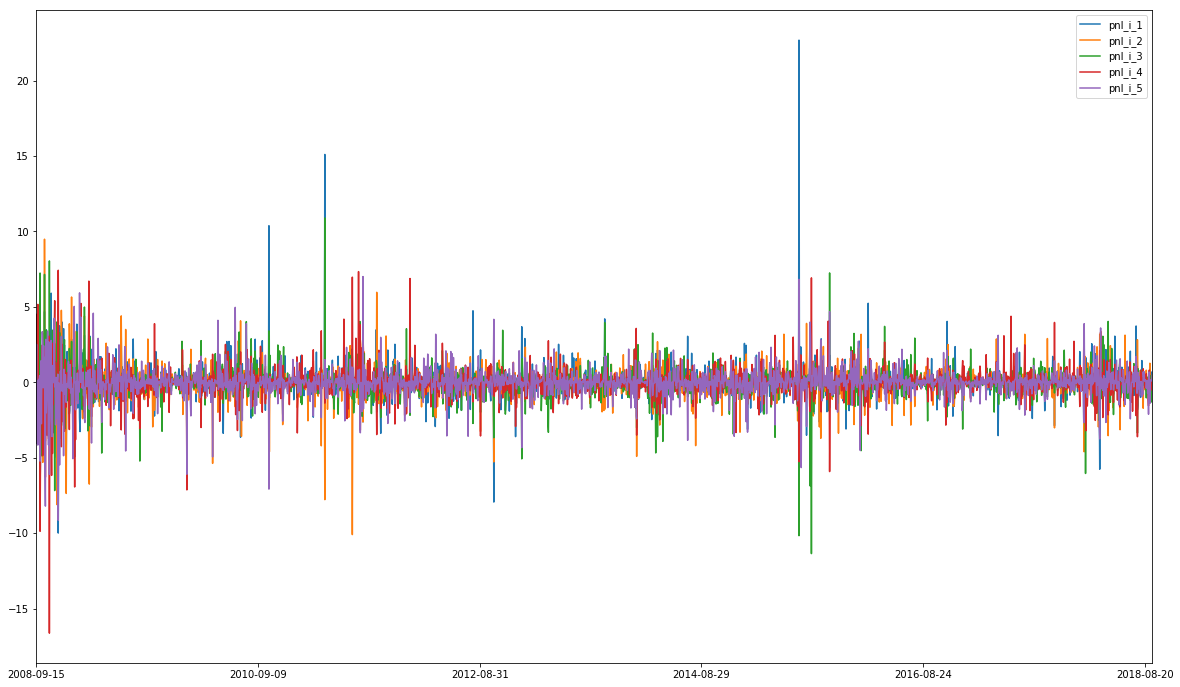

In [119]:
#plots for question 3.4
googlePrediction.filter(regex=('pnl_i_*')).plot()
plt.show()

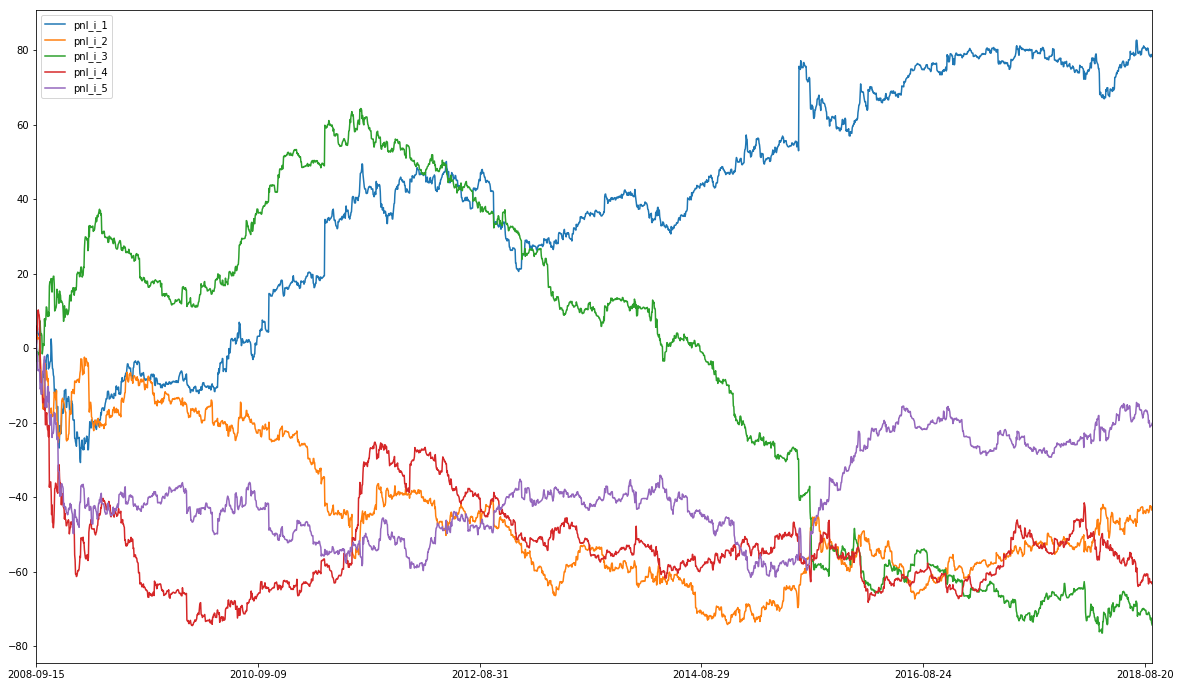

In [120]:
#cummulative summ plots for question 3.4
googlePrediction.filter(regex=('pnl_i*')).cumsum().plot()
plt.show()

## Question 4.

In [127]:
#lets calculate sharpe ratio for f_i
SE=googlePrediction['pnl_i_1'].mean()/np.sqrt(googlePrediction['pnl_i_1'].var())
#calculation of hitrate: 
#create array of ones and zeros (1 if pnl_i==p_i), and calculate ratio of array sum and array length
hitRate=(np.select([np.sign(googlePrediction['pnl_i_1'])==np.sign(googlePrediction['GOOGL'])], 
          [1], default=0)).sum()/googlePrediction.shape[0]

In [122]:
googlePrediction['hits_1']=np.select([np.sign(googlePrediction['pnl_i_1'])==np.sign(googlePrediction['GOOGL'])], 
          [1], default=0)

In [368]:
sharpeRatios=[]
hitRates=[]
for i in range (1,10000): # 2 following distribution plots where made with 10^6 samples, reduced here to 10000 to speed up calculation
    np.random.seed(i) #making result reprodusible
    #GP for "google prediction"
    GP=normalizedReturns[['GOOGL']]
    GP=GP.dropna()

    f_i = pd.Series(np.random.normal(size=GP.shape[0]), index=GP.index)
    f_i=f_i.rename('f_i')
    GP=pd.concat((GP, f_i), axis=1)
    GP['pnl_i']=GP['GOOGL']*GP['f_i']
    sharpeRatio=GP['pnl_i'].mean()/np.sqrt(GP['pnl_i'].var())
    hitRate=(np.select([np.sign(GP['pnl_i'])==np.sign(GP['GOOGL'])], 
          [1], default=0)).sum()/GP.shape[0]
    sharpeRatios.append(sharpeRatio)
    hitRates.append(hitRate)

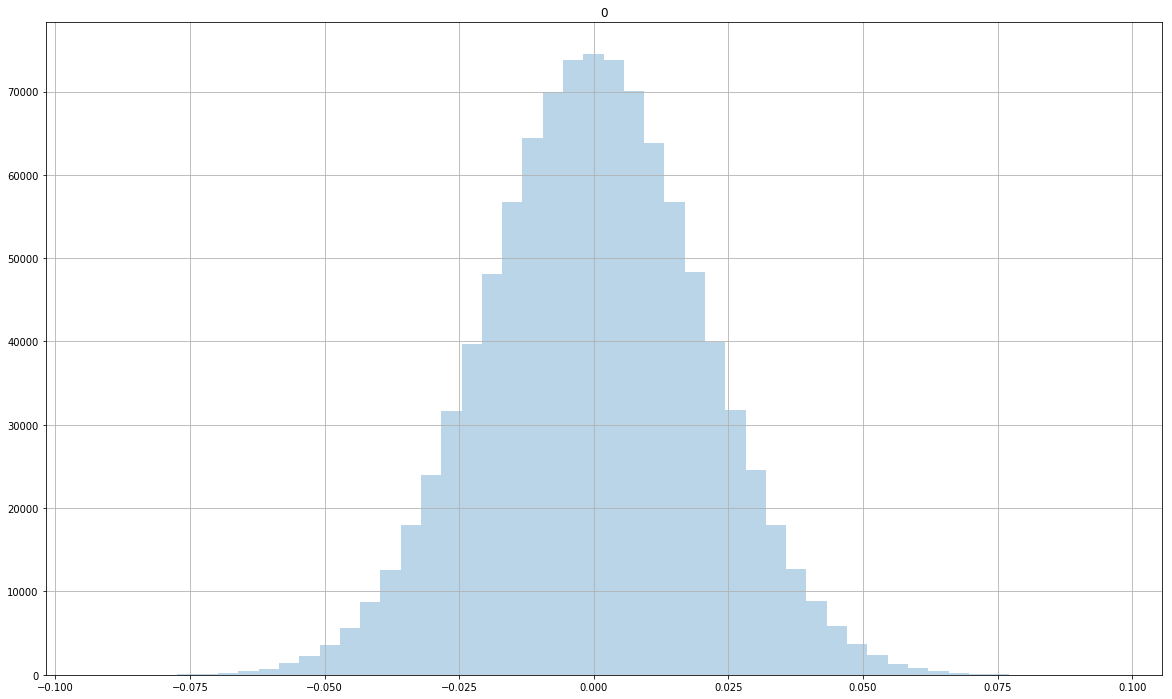

In [228]:
pd.DataFrame(sharpeRatios).hist(bins=50, alpha=0.3)
plt.show()

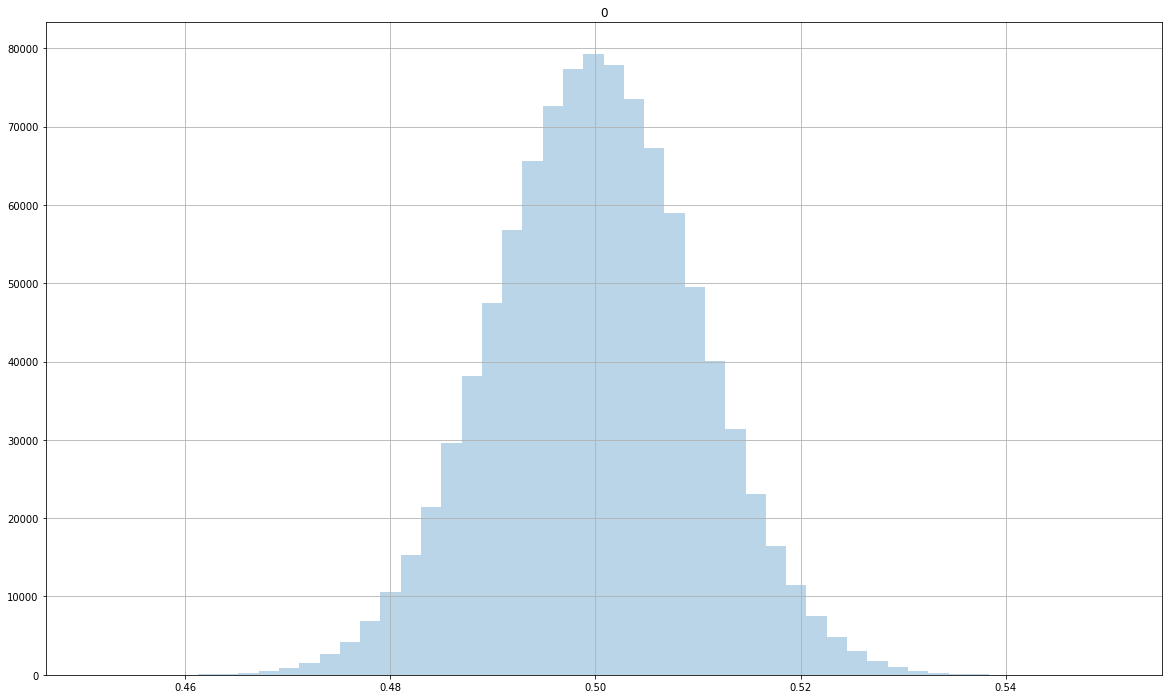

In [227]:
pd.DataFrame(hitRates).hist(bins=50, alpha=0.3)
plt.show()

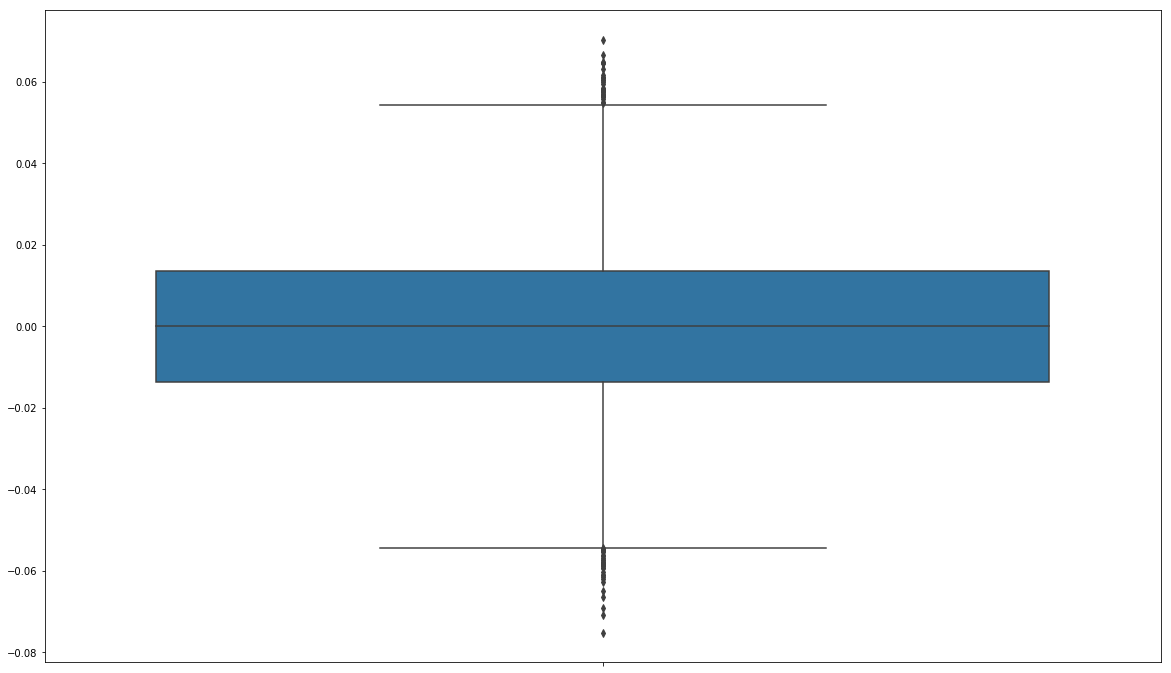

norm            p: 0.913227939959        p-value: 0.00559276745432
t               p: 0.913306130238        p-value: 0.00559203574789
lognorm         p: 0.77448139348         p-value: 0.00661222505382
gamma           p: 0.884278599167        p-value: 0.00584398072047


In [369]:
#boxplot sharp ratios distribution and determine what distribution is it
sns.boxplot(sharpeRatios, orient='v')
plt.show()
findDistribution(sharpeRatios)

#### According to kolmagorov-smirnov test, SP has normal distribution

### Generating hit ratio from 0 to 1 and corresponding f_i and pnl.
We can clearly see that with normally distributed f_i we get hit ratio distribution with mean 0.5 and sigma 0.01. That is to be expected, we cant get far from 50-50 ratio of zeros and ones using normal distribution and several thousands of samples.

We need to create artifitial arrays corresponding to hit ratios from 0 to 1 and recalculate sign of corresponding f_i. Using this modified f_i (which no longer follows normal distribution) we can calculate various pnl_i corresponding to all values of hit ratio between 0 and 1

In [313]:
#generate 
sharpeRatios=[]
hitRates=[]
for i in range (0,10000): 
    np.random.seed(i) #making result reprodusible
    
    #GP for "google prediction"
    GP=normalizedReturns[['GOOGL']]
    GP=GP.dropna()
    
    #creating artifitial array of hits
    onesCount = i-i//GP.shape[0]*GP.shape[0] #count of 1 (from 0 to full array of 1) in the array depending on iteration number 
    hits = np.zeros(GP.shape[0]) #array of zeros
    hits[0:onesCount]=1 #change some zeros to 1
    np.random.shuffle(hits) #randmly shuffle the array
    hits = pd.Series(hits, index=GP.index)
    hits = hits.rename('hits')
    GP = pd.concat((GP, hits), axis=1)
    
    #create normally distributed f_i
    f_i = pd.Series(np.random.normal(size=GP.shape[0]), index=GP.index)
    f_i=f_i.rename('f_i')
    GP=pd.concat((GP, f_i), axis=1)
    #change or not change f_i sign based on hit value
    conditions = [
    ((np.sign(GP['GOOGL']) == np.sign(GP['f_i'])) & (GP['hits'] == 1)),
    ((np.sign(GP['GOOGL']) != np.sign(GP['f_i'])) & (GP['hits'] == 1)),
    ((np.sign(GP['GOOGL']) == np.sign(GP['f_i'])) & (GP['hits'] == 0)),
    ((np.sign(GP['GOOGL']) != np.sign(GP['f_i'])) & (GP['hits'] == 0))
    ]
    choices = [GP['f_i'],
               np.negative(GP['f_i']),
               np.negative(GP['f_i']),
               GP['f_i']
    ]
    #column of modified f_i and corresponding pnl
    GP['f_i_mod']=np.select(conditions, choices)
    GP['pnl_i_mod']=GP['GOOGL']*GP['f_i_mod'] 
    sharpeRatio=GP['pnl_i_mod'].mean()/np.sqrt(GP['pnl_i_mod'].var())
    hitRate=hits.sum()/GP.shape[0]
    sharpeRatios.append(sharpeRatio)
    hitRates.append(hitRate)

#### Now we can get a plot varying hit_rate from 0 to 1.0 on the x-axis and computing the corresponding distribution of SR on the y-axis:

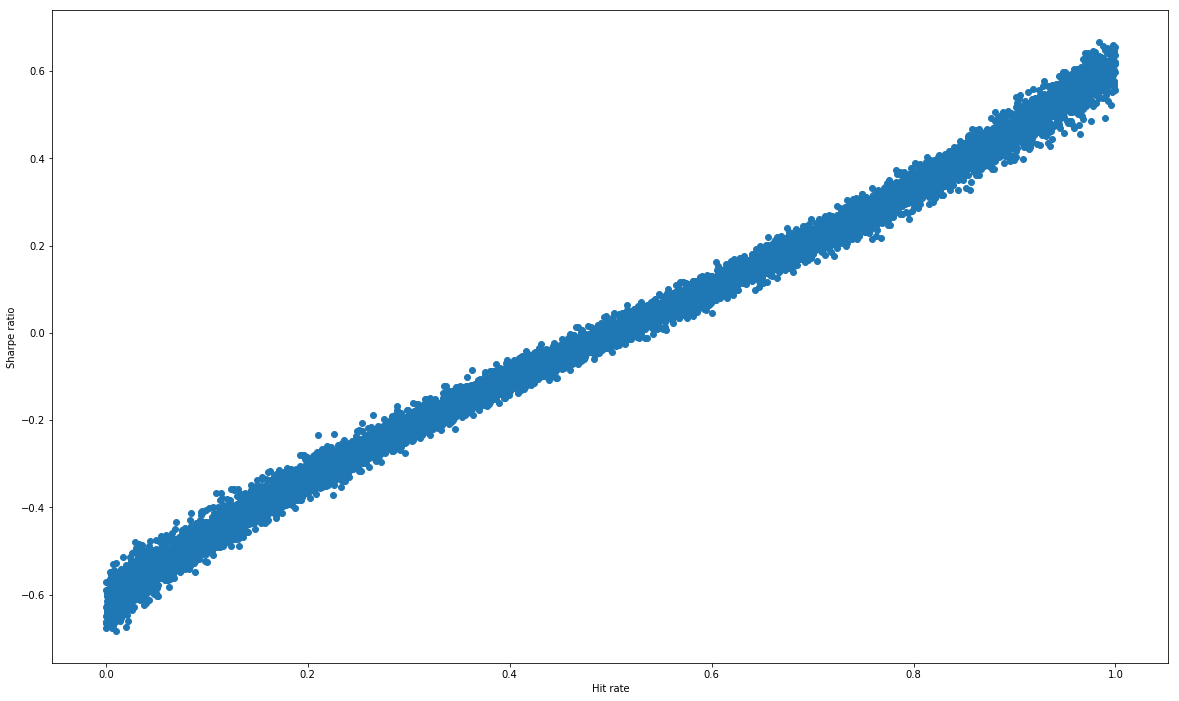

In [315]:
plt.scatter(hitRates,sharpeRatios)
plt.xlabel('Hit rate')
plt.ylabel('Sharpe ratio')
plt.show()

#### Sharpe ratio distribition now is also changed, because it was calculated from modified f_i_mod values:

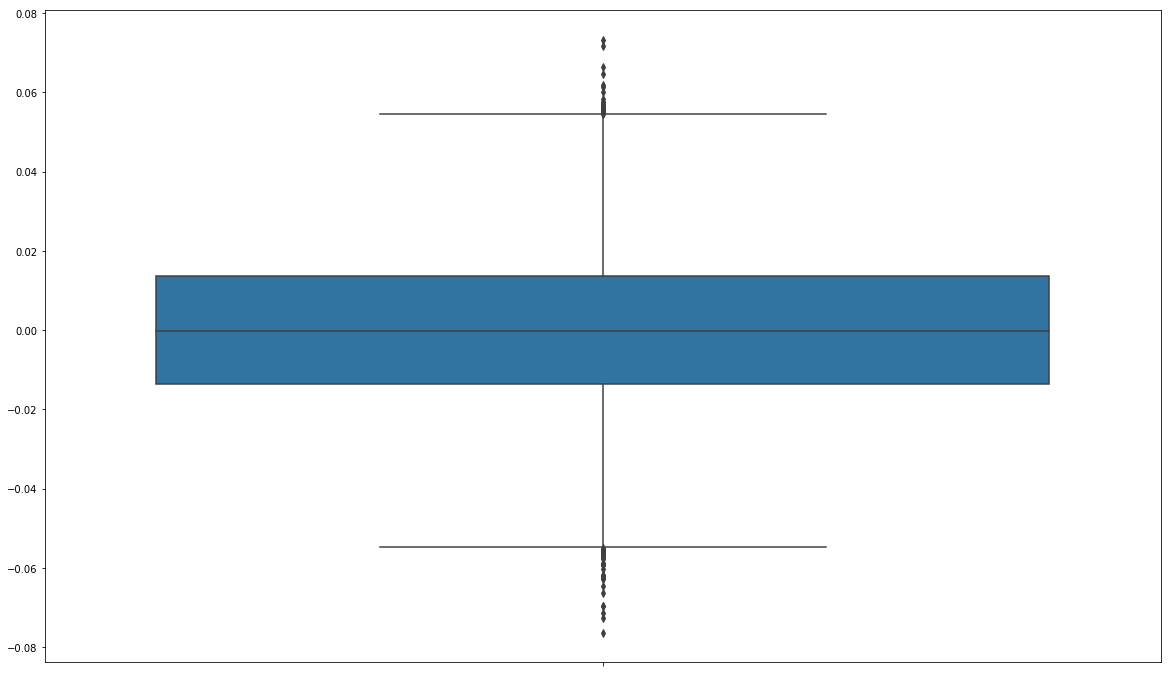

In [320]:
sns.boxplot(sharpeRatios, orient='v')
plt.show()

In [ ]:
distribution of SR 

## Question 5

In [370]:
sharpeRatios=[]
RMSEs=[]
MADs=[]
for i in range (0,10000):
    np.random.seed(i) #making result reprodusible

    #GP for "google prediction"
    GP=normalizedReturns[['GOOGL']]
    GP=GP.dropna()
    
    #generate predictions f_i and calculate pnl_i
    f_i = pd.Series(np.random.normal(size=GP.shape[0]), index=GP.index)
    f_i=f_i.rename('f_i')
    GP=pd.concat((GP, f_i), axis=1)
    GP['pnl_i']=GP['GOOGL']*GP['f_i']
    
    #calculating metrics
    sharpeRatio=GP['pnl_i'].mean()/np.sqrt(GP['pnl_i'].var())
    RMSE=(np.sqrt(((GP['f_i'] - GP['GOOGL']) ** 2).mean()))
    MAD=mean_absolute_error(GP['GOOGL'],GP['f_i'])
    sharpeRatios.append(sharpeRatio)
    RMSEs.append(RMSE)
    MADs.append(MAD)

#### Plotting SR vs RMSE, MAD or hit ratio

In [372]:
metric, metricsName = RMSEs, 'RMSE' #possible values: hitRates, RMSEs, MADs

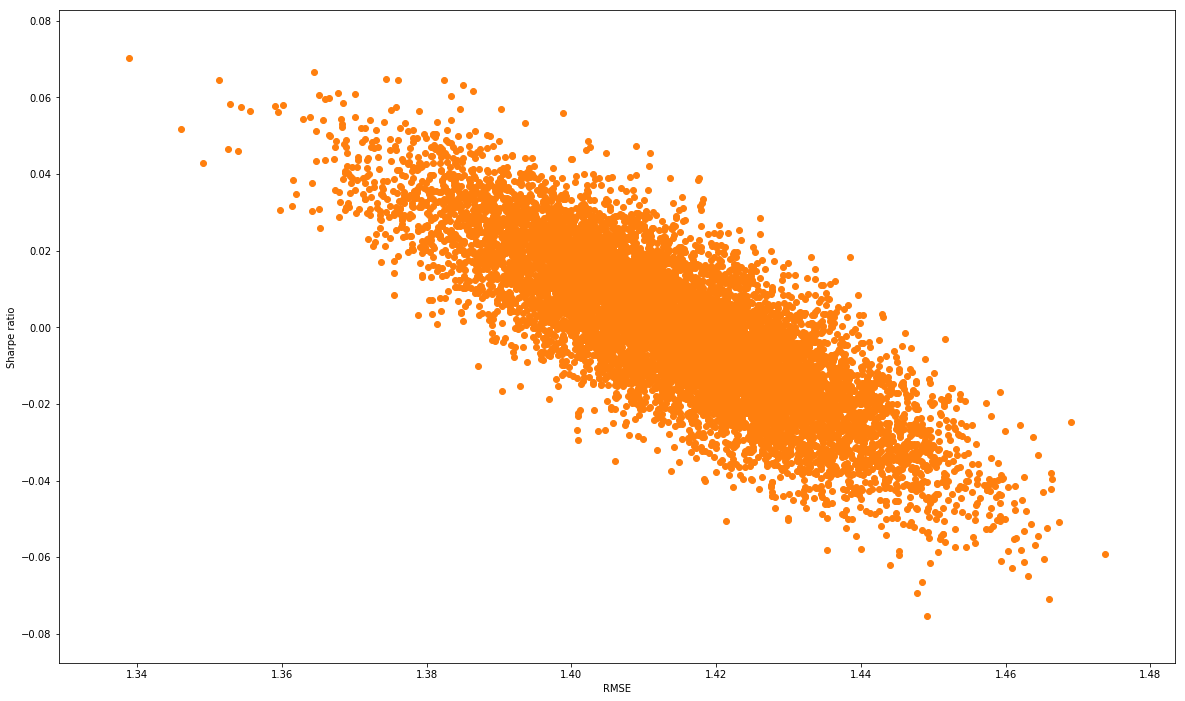

In [373]:
plt.scatter(metric,sharpeRatios)
plt.xlabel(metricsName)
plt.ylabel('Sharpe ratio')
plt.show()

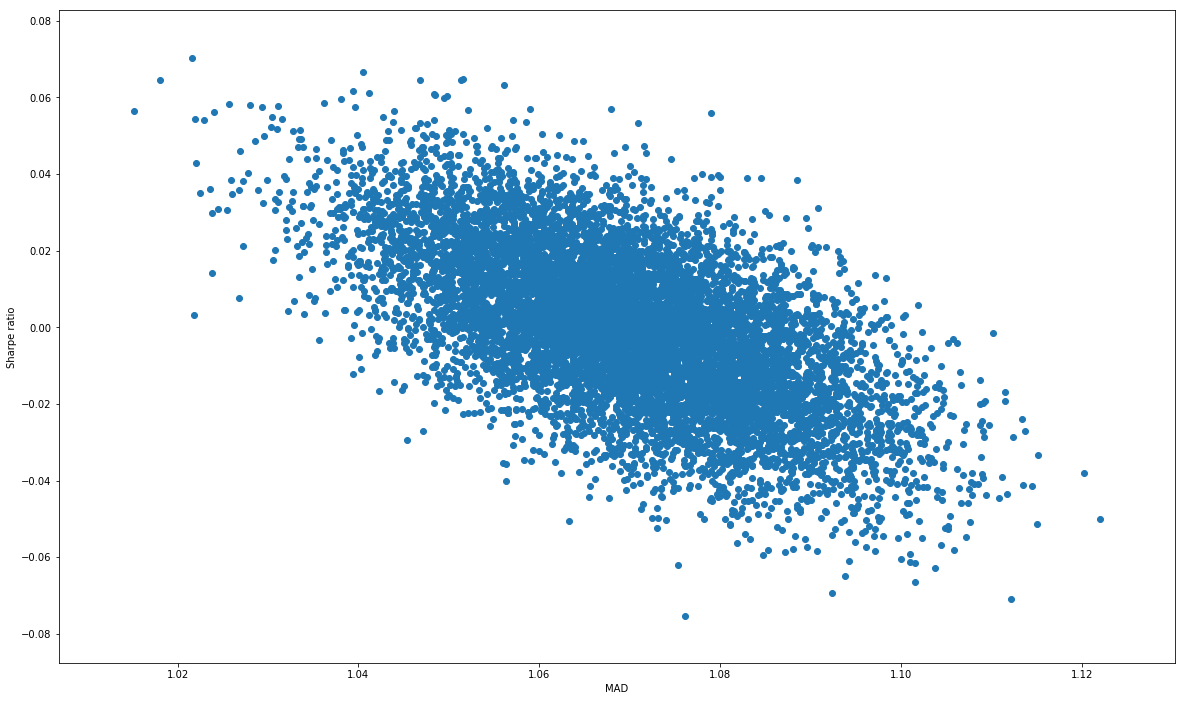

In [374]:
plt.scatter(MADs,sharpeRatios)
plt.xlabel('MAD')
plt.ylabel('Sharpe ratio')
plt.show()

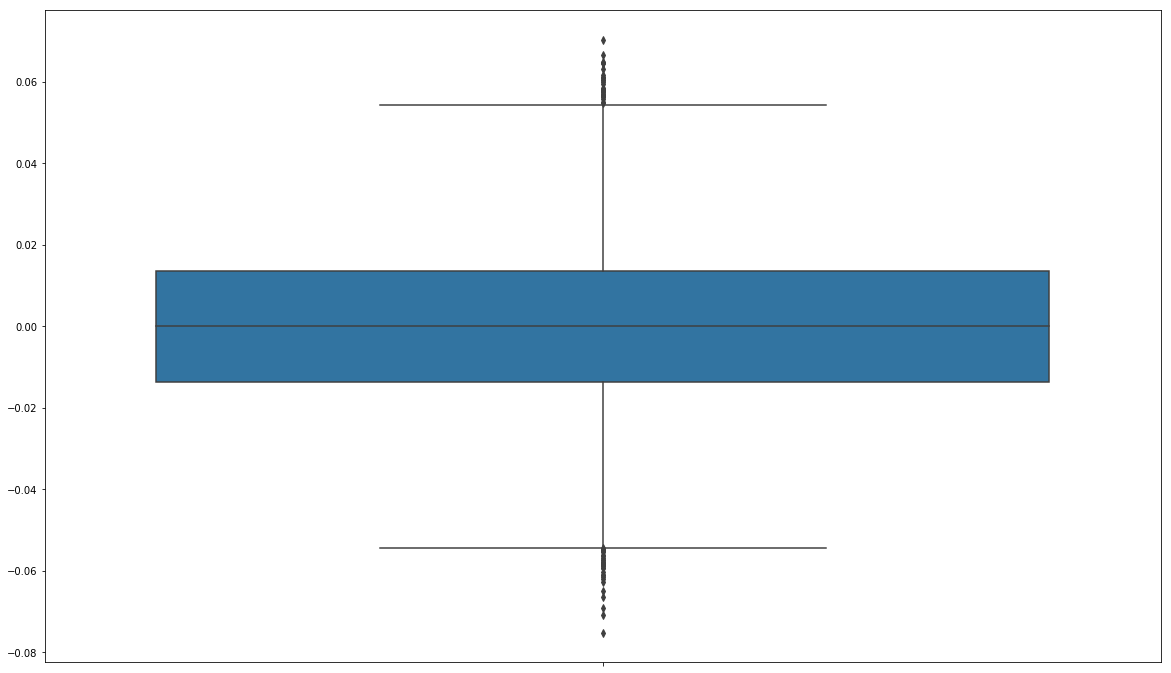

norm            p: 0.914013050146        p-value: 0.00558512537092
t               p: 0.915063709741        p-value: 0.0055752173744
lognorm         p: 0.845896396488        p-value: 0.0061351573834
gamma           p: 0.88650911088         p-value: 0.0058255133257


In [375]:
#boxplot sharp ratios distribution and determine what distribution is it
sns.boxplot(sharpeRatios, orient='v')
plt.show()
findDistribution(sharpeRatios)

### Question 5 summary
* SR has diffrent dependance with metrics RMSE and MAD: the lower is the metric, the higher (better) is SR. This is behaviour  is opposite to hit ratio. This is expected, because the lower are the errors, the better is result.
* Distribuition of SHarpe ratio itself doesn't change, because calculation of RMSE, MAD or Hit ratio doesn't affect calculation of SE. It remains normal.